In [56]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from datetime import datetime as dt

from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR, get_tensor_dataset, encode_batch, BL62_VALUES, BL62FREQ_VALUES, get_array_dataset
from src.models import Net, ConvBlock, LinearBlock
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from src.metrics import get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.train_eval import train_loop, nested_kcv_train_nn, evaluate_trained_models_nn
from src.train_eval import kcv_tune_sklearn, evaluate_trained_models_sklearn, nested_kcv_train_sklearn

from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump

if torch.cuda.is_available():    
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device = "cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'
    
from src.partition_tools import pipeline_stratified_kfold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

RESDIR='../output/train_eval/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3070 Laptop GPU


# datasets reload / re-save (for nnalign & prime)

In [64]:
# Datasets
cedar = pd.read_csv('../data/partitioned_traindata/cedar_10fold.csv')
cedar_hp_low = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_10fold.csv')
cedar_hp_uni = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_rank120_10fold.csv')
cedar_viral = pd.read_csv('../data/partitioned_traindata/cedar_viral_10fold.csv')
prime = pd.read_excel('../data/partitioned_traindata/PRIME_dataset.xlsx', comment = '#', skiprows=2)

In [17]:
# Saving for nnalign
cedar[['Peptide', 'agg_label']].to_csv('../../../nnalign/partitioned_data/cedar.pep', index=False,header=False, sep='\t')
cedar_hp_low[['Peptide', 'agg_label']].to_csv('../../../nnalign/partitioned_data/cedar_hp_low.pep', index=False,header=False, sep='\t')
cedar_hp_uni[['Peptide', 'agg_label']].to_csv('../../../nnalign/partitioned_data/cedar_hp_uni.pep', index=False,header=False, sep='\t')
cedar_viral[['Peptide', 'agg_label']].to_csv('../../../nnalign/partitioned_data/cedar_viral.pep', index=False,header=False, sep='\t')
prime[['Mutant', 'Immunogenicity']].to_csv('../../../nnalign/partitioned_data/prime.pep', index=False,header=False, sep='\t')

In [26]:
# Saving for PRIME
cedar[['Peptide']].to_csv('../../../gfeller_tools/PRIME/data/cedar.pep', index=False,header=False)
cedar_hp_low[['Peptide']].to_csv('../../../gfeller_tools/PRIME/data/cedar_hp_low.pep', index=False,header=False)
cedar_hp_uni[['Peptide']].to_csv('../../../gfeller_tools/PRIME/data/cedar_hp_uni.pep', index=False,header=False)
cedar_viral[['Peptide']].to_csv('../../../gfeller_tools/PRIME/data/cedar_viral.pep', index=False,header=False)
prime[['Mutant']].to_csv('../../../gfeller_tools/PRIME/data/prime.pep', index=False,header=False)

# baselines (loading nnalign results, prime results)

In [32]:
# nn align
nndir = '../../../nnalign/partitioned_output/'
nnalign_cedar = pd.read_csv(f'{nndir}cedar.pep_39077/cedar.pep_39077.lg6.sorted.pred', sep = '\t')
nnalign_cedar_hp_low = pd.read_csv(f'{nndir}cedar_hp_low.pep_34256/cedar_hp_low.pep_34256.lg6.sorted.pred', sep = '\t')
nnalign_cedar_hp_uni = pd.read_csv(f'{nndir}cedar_hp_uni.pep_28097/cedar_hp_uni.pep_28097.lg6.sorted.pred', sep = '\t')
nnalign_cedar_viral = pd.read_csv(f'{nndir}cedar_viral.pep_2684/cedar_viral.pep_2684.lg6.sorted.pred', sep = '\t')
nnalign_prime = pd.read_csv(f'{nndir}prime.pep_12391/prime.pep_12391.lg6.sorted.pred', sep = '\t')

In [35]:
# PRIME
primedir='../../../gfeller_tools/PRIME/output/'
prime_cedar = pd.read_csv(f'{primedir}cedar_PRIME.out', comment = '#', sep = '\t')
prime_cedar_hp_low = pd.read_csv(f'{primedir}cedar_hp_low_PRIME.out', comment = '#', sep = '\t')
prime_cedar_hp_uni = pd.read_csv(f'{primedir}cedar_hp_uni_PRIME.out', comment = '#', sep = '\t')
prime_cedar_viral = pd.read_csv(f'{primedir}cedar_viral_PRIME.out', comment = '#', sep = '\t')
prime_prime = pd.read_csv(f'{primedir}prime_PRIME.out', comment = '#', sep = '\t')

In [41]:
display(prime_cedar.head(1))
display(nnalign_cedar.sort_values('Peptide', ascending=True).head(1))
display(cedar.head(1))

,Peptide,%Rank_bestAllele,Score_bestAllele,%RankBinding_bestAllele,BestAllele,%Rank_A0101,Score_A0101,%RankBinding_A0101,%Rank_A0201,Score_A0201,%RankBinding_A0201,%Rank_A0202,Score_A0202,%RankBinding_A0202,%Rank_A0203,Score_A0203,%RankBinding_A0203,%Rank_A0205,Score_A0205,%RankBinding_A0205,%Rank_A0206,Score_A0206,%RankBinding_A0206,%Rank_A0210,Score_A0210,%RankBinding_A0210,%Rank_A0211,Score_A0211,%RankBinding_A0211,%Rank_A0224,Score_A0224,%RankBinding_A0224,%Rank_A0301,Score_A0301,%RankBinding_A0301,%Rank_A0302,Score_A0302,%RankBinding_A0302,%Rank_A1101,Score_A1101,%RankBinding_A1101,%Rank_A1102,Score_A1102,%RankBinding_A1102,%Rank_A2402,Score_A2402,%RankBinding_A2402,%Rank_A2501,Score_A2501,%RankBinding_A2501,%Rank_A2601,Score_A2601,%RankBinding_A2601,%Rank_A2902,Score_A2902,%RankBinding_A2902,%Rank_A3001,Score_A3001,%RankBinding_A3001,%Rank_A3002,Score_A3002,%RankBinding_A3002,%Rank_A3101,Score_A3101,%RankBinding_A3101,%Rank_A3301,Score_A3301,%RankBinding_A3301,%Rank_A6801,Score_A6801,%RankBinding_A6801,%Rank_A6802,Score_A6802,%RankBinding_A6802,%Rank_A6901,Score_A6901,%RankBinding_A6901,%Rank_B0702,Score_B0702,%RankBinding_B0702,%Rank_B0801,Score_B0801,%RankBinding_B0801,%Rank_B1302,Score_B1302,%RankBinding_B1302,%Rank_B1501,Score_B1501,%RankBinding_B1501,%Rank_B1801,Score_B1801,%RankBinding_B1801,%Rank_B2705,Score_B2705,%RankBinding_B2705,%Rank_B3501,Score_B3501,%RankBinding_B3501,%Rank_B3503,Score_B3503,%RankBinding_B3503,%Rank_B3701,Score_B3701,%RankBinding_B3701,%Rank_B3801,Score_B3801,%RankBinding_B3801,%Rank_B3901,Score_B3901,%RankBinding_B3901,%Rank_B3906,Score_B3906,%RankBinding_B3906,%Rank_B4001,Score_B4001,%RankBinding_B4001,%Rank_B4002,Score_B4002,%RankBinding_B4002,%Rank_B4102,Score_B4102,%RankBinding_B4102,%Rank_B4402,Score_B4402,%RankBinding_B4402,%Rank_B4403,Score_B4403,%RankBinding_B4403,%Rank_B4408,Score_B4408,%RankBinding_B4408,%Rank_B4901,Score_B4901,%RankBinding_B4901,%Rank_B5101,Score_B5101,%RankBinding_B5101,%Rank_B5201,Score_B5201,%RankBinding_B5201,%Rank_B5401,Score_B5401,%RankBinding_B5401,%Rank_B5601,Score_B5601,%RankBinding_B5601,%Rank_B5701,Score_B5701,%RankBinding_B5701,%Rank_C0102,Score_C0102,%RankBinding_C0102,%Rank_C0303,Score_C0303,%RankBinding_C0303,%Rank_C0304,Score_C0304,%RankBinding_C0304,%Rank_C0401,Score_C0401,%RankBinding_C0401,%Rank_C0501,Score_C0501,%RankBinding_C0501,%Rank_C0602,Score_C0602,%RankBinding_C0602,%Rank_C0701,Score_C0701,%RankBinding_C0701,%Rank_C0702,Score_C0702,%RankBinding_C0702,%Rank_C0802,Score_C0802,%RankBinding_C0802,%Rank_C1202,Score_C1202,%RankBinding_C1202,%Rank_C1203,Score_C1203,%RankBinding_C1203,%Rank_C1402,Score_C1402,%RankBinding_C1402,%Rank_C1403,Score_C1403,%RankBinding_C1403,%Rank_C1502,Score_C1502,%RankBinding_C1502
0,AAAAAAQQIQV,4.676,0.008733,0.703,B5601,53.352,0.000394,43.908,9.024,0.004986,1.575,7.292,0.006073,1.146,21.67,0.002152,7.655,10.884,0.004964,2.435,10.817,0.005084,2.347,10.817,0.005084,2.347,17.179,0.002364,4.592,9.024,0.004986,1.575,22.082,0.001554,8.905,4.986,0.007973,0.827,17.052,0.002313,5.391,14.752,0.002904,3.974,47.588,0.000471,35.674,37.133,0.001013,32.606,28.825,0.00161,19.285,75.231,0.000198,45.401,22.21,0.001544,8.978,44.185,0.000542,30.366,26.009,0.001365,10.418,37.242,0.000759,20.653,11.81,0.003217,3.448,8.031,0.00524,1.456,8.031,0.00524,1.456,11.744,0.003396,3.193,42.575,0.000598,23.818,9.197,0.004675,1.99,31.007,0.001022,14.668,55.872,0.000365,48.03,36.341,0.0008,19.453,23.393,0.001577,8.748,24.64,0.001453,9.663,41.469,0.000616,23.042,29.387,0.001167,12.556,28.008,0.001211,16.751,32.8,0.00095,22.146,18.54,0.001948,6.725,12.331,0.002902,3.978,12.331,0.002902,3.978,30.701,0.001122,13.145,29.52,0.001172,12.493,30.701,0.001122,13.145,17.652,0.002185,5.807,18.356,0.002061,6.258,24.274,0.001376,10.324,28.344,0.001152,12.747,4.676,0.008733,0.703,23.338,0.001616,8.487,34.368,0.000892,23.782,29.835,0.001021,14.687,29.162,0.001051,14.193,49.667,0.000436,38.968,21.674,0.001559,8.87,47.83,0.000462,15.988,56.754,0.00034,52.255,57.23

,Core,P1,Measure,Prediction,Peptide,Gap_pos,Gap_lgt,Insert_pos,Insert_lgt,Core+gap,P1_Rel
1396,AAAAAA,0,0.001,0.04789,AAAAAAQQIQV,0,0,0,0,AAAAAA,0.6


,Peptide,HLA,trueHLA_EL_rank,agg_label,fold,BA_rank,BA_score,PMIDs,core,icore,label,len,percentage_pos,pred_EL_rank,pred_EL_score,pred_HLA,responses,total_count
0,AAAAAAQQIQV,HLA-B07:02,26.7692,0,8,11.9024,0.1632,27198675,AAAAAQIQV,AAAAAAQQIQV,Negative,11,0.0,5.2822,0.0166,HLA-A68:02,Negative,1


## Merging 

In [65]:
import copy
def merging(df, df_nnalign, df_prime):
    df = df.sort_values('Peptide', ascending=True).reset_index(drop=True)
    df_nnalign = df_nnalign.sort_values('Peptide', ascending=True).reset_index(drop=True)
    df_prime = df_prime.sort_values('Peptide', ascending=True).reset_index(drop=True)
    out = copy.deepcopy(df)
    tmp = df_nnalign.rename(columns={'Prediction':'nnalign_score'}).merge(df_prime.rename(columns={'%Rank_bestAllele':'MixMHCrank',
                                                    'Score_bestAllele':'PRIME_score',
                                                    'BestAllele':'MixMHCallele'})[['Peptide', 'MixMHCrank', 'PRIME_score', 'MixMHCallele']],
                           left_index=True, right_index=True)
    out = out.merge(tmp, left_index=True, right_index=True)
    return out

In [66]:
cedar = merging(cedar, nnalign_cedar, prime_cedar)
cedar_hp_low = merging(cedar_hp_low, nnalign_cedar_hp_low, prime_cedar_hp_low)
cedar_hp_uni = merging(cedar_hp_uni, nnalign_cedar_hp_uni, prime_cedar_hp_uni)
cedar_viral = merging(cedar_viral, nnalign_cedar_viral, prime_cedar_viral)
prime = merging(prime.rename(columns={'Mutant':'Peptide'}), nnalign_prime, prime_prime)

## quick roc check

Text(0.5, 1.0, 'Comparison of baselines for PRIME')

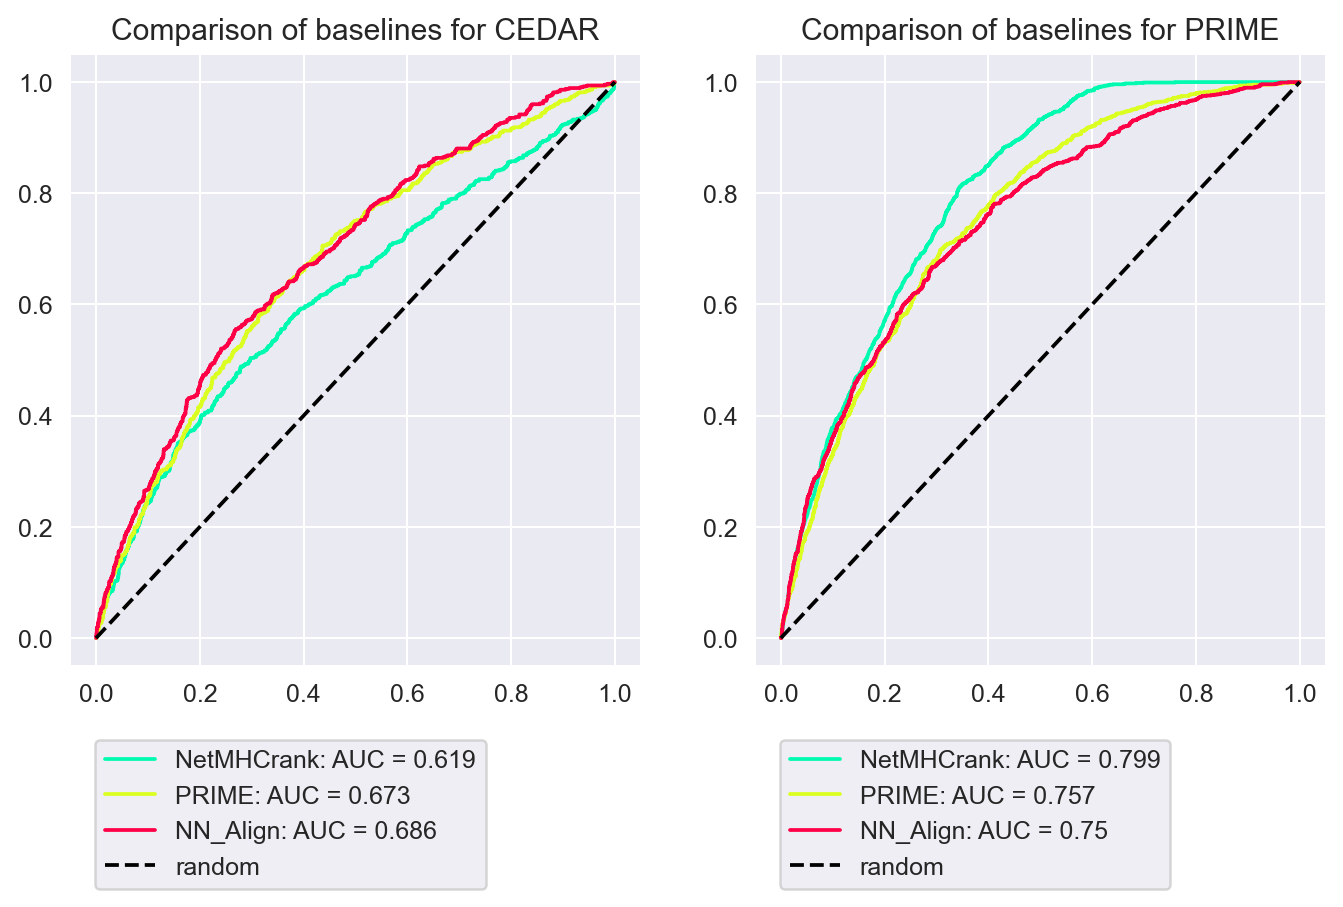

In [116]:
# For CEDAR
from sklearn.metrics import roc_auc_score, roc_curve
#FOR CEDAR
# EL rank
fpr_netmhc, tpr_netmhc, _ = roc_curve(cedar['agg_label'].values,  -1* cedar['trueHLA_EL_rank'].values)
auc_netmhc = roc_auc_score(cedar['agg_label'].values, -1*cedar['trueHLA_EL_rank'].values)
# PRIME
fpr_prime, tpr_prime, _ = roc_curve(cedar['agg_label'].values, cedar['PRIME_score'].values)
auc_prime = roc_auc_score(cedar['agg_label'].values, cedar['PRIME_score'].values)
# nnalign
fpr_nnalign, tpr_nnalign, _ = roc_curve(cedar['agg_label'].values, cedar['nnalign_score'].values)
auc_nnalign = roc_auc_score(cedar['agg_label'].values, cedar['nnalign_score'].values)

sns.set_palette('gist_ncar', n_colors=3)
f,a = plt.subplots(1,2, figsize=(9,4.5))
a[0].plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}')
a[0].plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}')
a[0].plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}')
a[0].plot([0,1],[0,1], label='random', ls = '--', c='k')
a[0].legend(bbox_to_anchor=(0.75, -0.1))
a[0].set_title('Comparison of baselines for CEDAR')
# FOR PRIME
# EL rank
fpr_netmhc, tpr_netmhc, _ = roc_curve(prime['Immunogenicity'].values,  -1* prime['NetMHCpanEL'].values)
auc_netmhc = roc_auc_score(prime['Immunogenicity'].values, -1*prime['NetMHCpanEL'].values)
# PRIME
fpr_prime, tpr_prime, _ = roc_curve(prime['Immunogenicity'].values, prime['PRIME_score'].values)
auc_prime = roc_auc_score(prime['Immunogenicity'].values, prime['PRIME_score'].values)
# nnalign
fpr_nnalign, tpr_nnalign, _ = roc_curve(prime['Immunogenicity'].values, prime['nnalign_score'].values)
auc_nnalign = roc_auc_score(prime['Immunogenicity'].values, prime['nnalign_score'].values)
a[1].plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}')
a[1].plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}')
a[1].plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}')
a[1].plot([0,1],[0,1], label='random', ls = '--', c='k')
a[1].legend(bbox_to_anchor=(0.75, -0.1))
a[1].set_title('Comparison of baselines for PRIME')

# old wrong results

Outer fold: 100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [04:56<00:00, 29.63s/it]


dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'concatenated'])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'concatenated'])


(<Figure size 1080x1080 with 1 Axes>, <AxesSubplot:title={'center':'PRIME'}>)

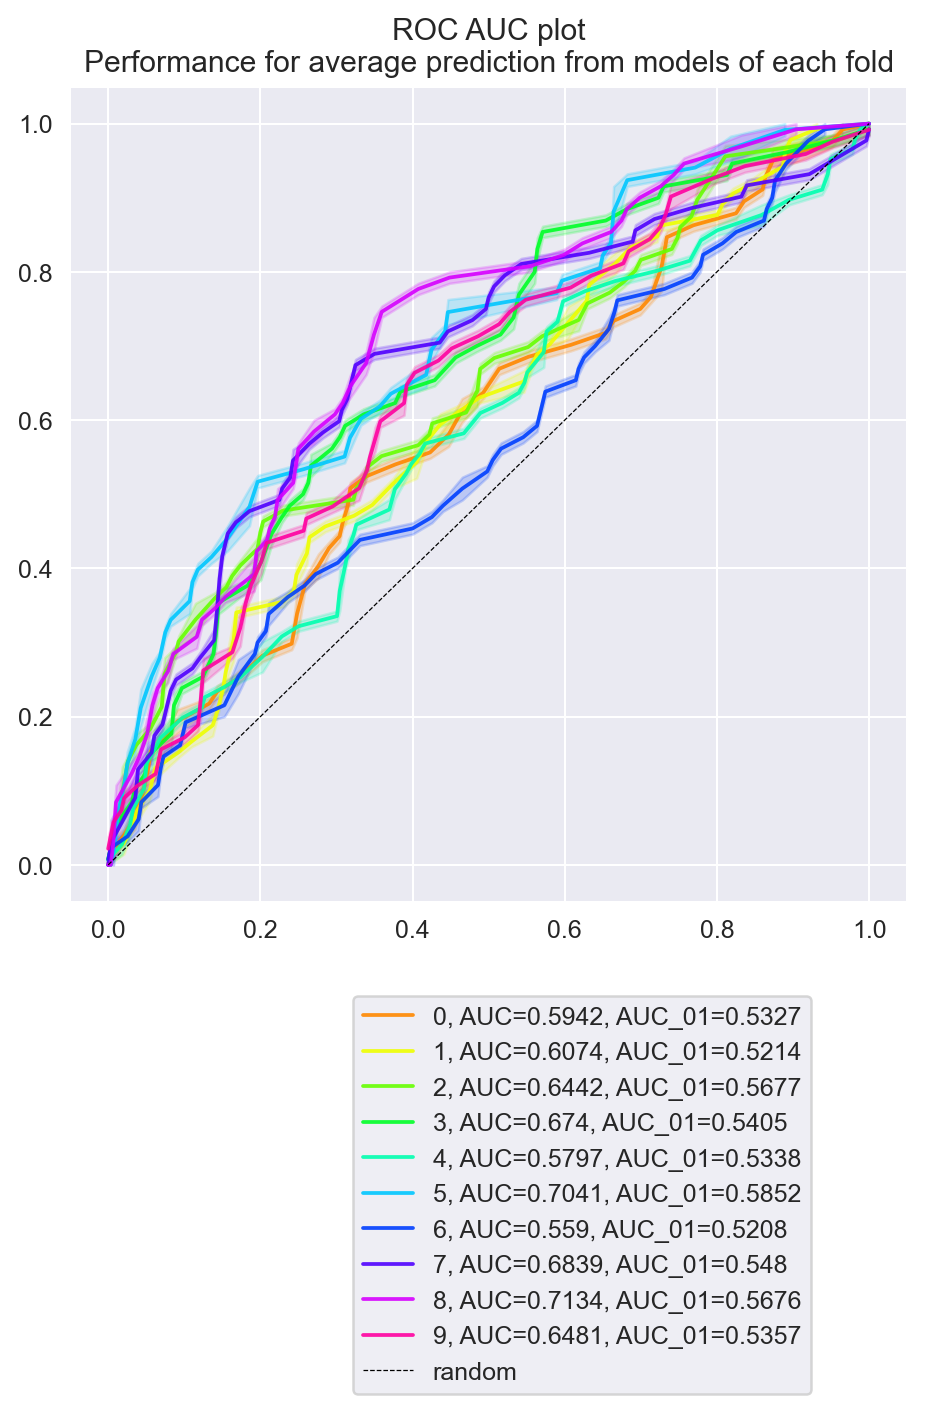

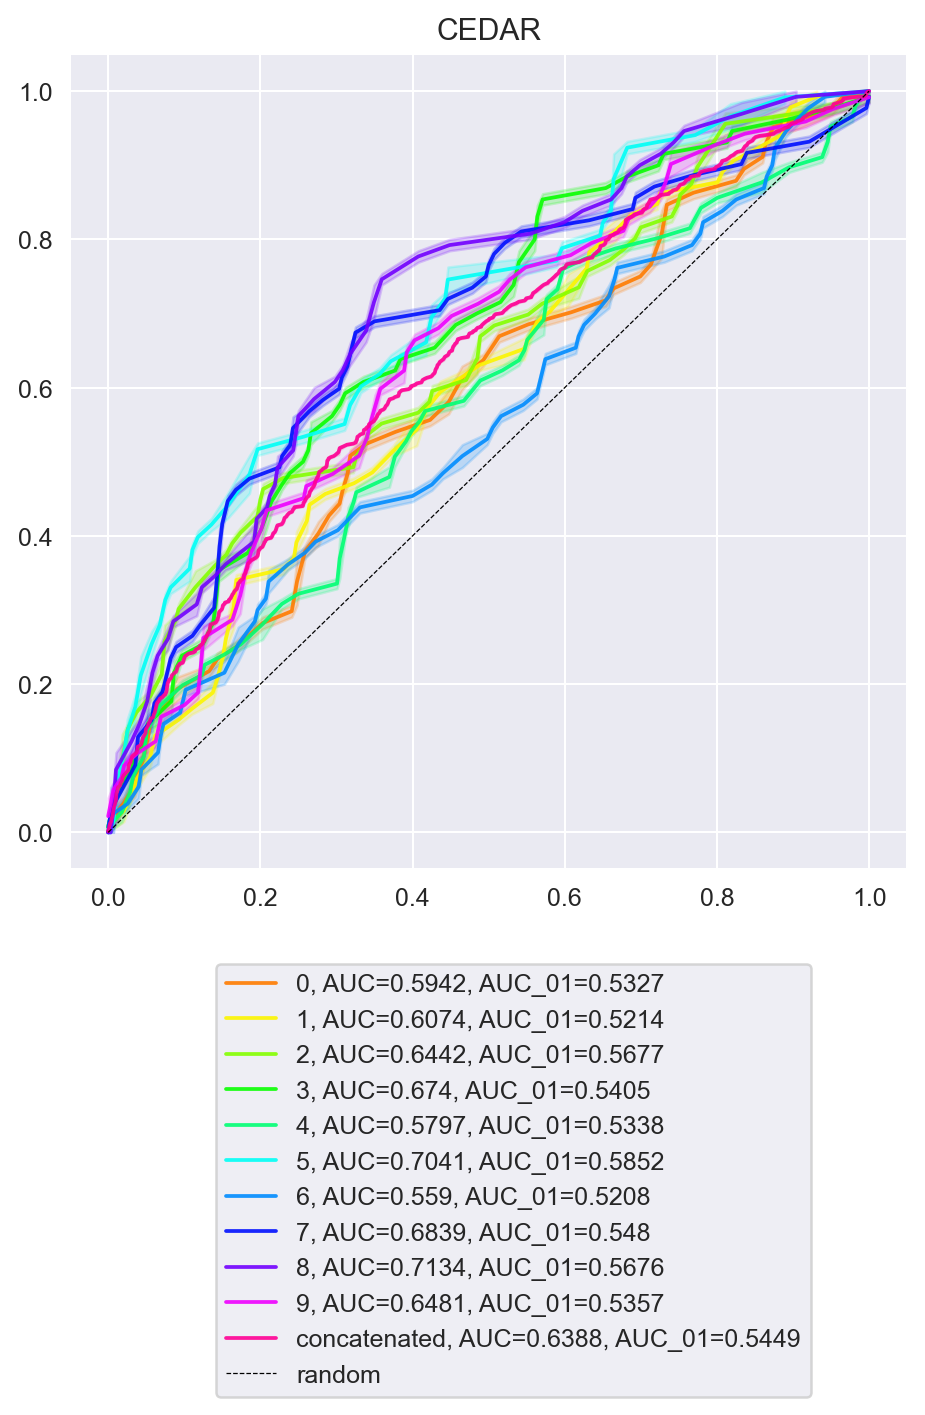

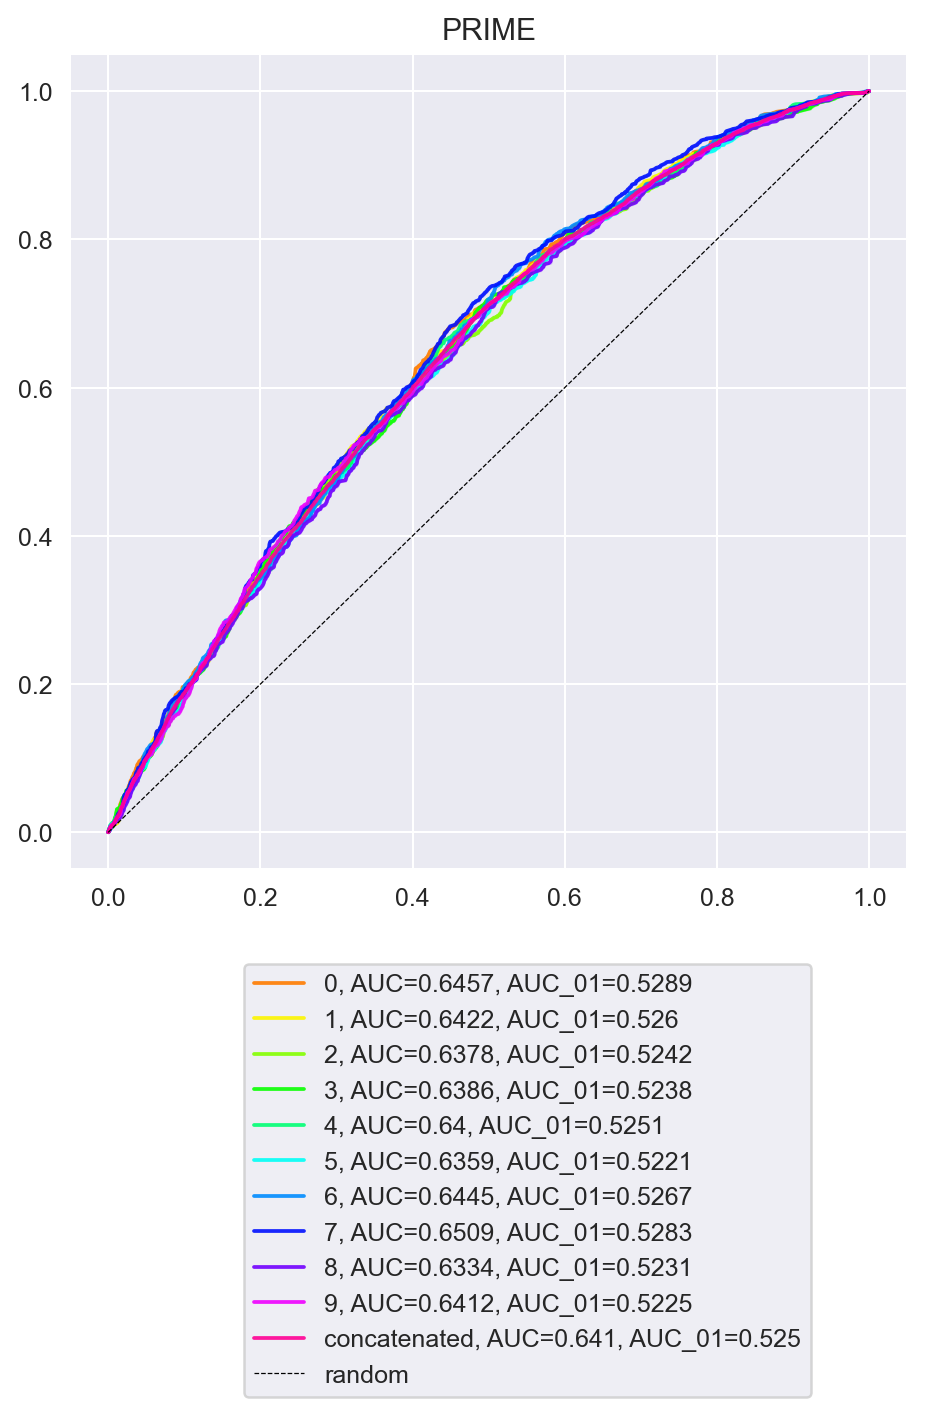

In [25]:
enc_kwargs_true = {'max_len':12,
              'encoding':'onehot',
              'blosum_matrix':None,
              'mask':False,
              'add_rank':True,
              'add_aaprop':True,
              'remove_pep':False,
              'standardize':True}
# model = RandomForestClassifier(n_estimators = 300, max_depth=5, ccp_alpha= 4.615e-7)
model = LogisticRegression(C=0.1, penalty = 'elasticnet', l1_ratio = 0.3, solver='saga')
models_std, train_metrics_std, test_metrics_std = nested_kcv_train_sklearn(dataset, model, ics, enc_kwargs_true)
plot_roc_auc_fold(test_metrics_std)

# STANDARDIZE = TRUE
from copy import deepcopy

prime_results_std = evaluate_trained_models_sklearn(prime_dataset, models_std, ics, None, 
                                                        train_metrics_std, enc_kwargs_true, concatenated=True)

cedar_results_std = evaluate_trained_models_sklearn(dataset, models_std, ics, train_dataframe=dataset, 
                                                    train_metrics=train_metrics_std, encoding_kwargs=enc_kwargs_true,
                                                    concatenated=True)
plot_roc_auc_fold(cedar_results_std, title = 'CEDAR')
plot_roc_auc_fold(prime_results_std, title = 'PRIME')

In [29]:
outdict={}
outdict['score_avg_prime_auc'] = np.mean([prime_results_std[k]['auc'] for k in prime_results_std.keys() if k != 'concatenated'])
outdict['score_avg_prime_auc_01'] = np.mean([prime_results_std[k]['auc_01'] for k in prime_results_std.keys() if k != 'concatenated'])
outdict['score_avg_prime_f1'] = np.mean([prime_results_std[k]['f1'] for k in prime_results_std.keys() if k != 'concatenated'])


In [31]:
prime_log = pkl_load('../output/traineval/run_220826_11h34m10s/log/prime_results_log.pkl')

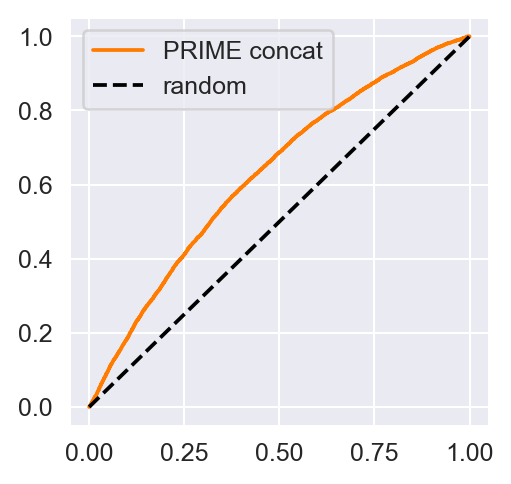

In [37]:
f,a = plt.subplots(1,1, figsize=(3,3))
a.plot(prime_log[0]['concatenated']['roc_curve'][0],prime_log[0]['concatenated']['roc_curve'][1],
         label='PRIME concat')
a.plot([0,1],[0,1],label='random', ls='--', c='k')
a.legend()

# New fixed results

In [541]:
x=pkl_load('../output/train_eval/run_220826_13h45m05s_rf/train_metrics_rf.pkl')

In [109]:
# Pickles with results&curves
cedar_log = pkl_load(f'{RESDIR}run_220826_13h42m44s_logreg/cedar_results_log.pkl')
prime_log = pkl_load(f'{RESDIR}run_220826_13h42m44s_logreg/prime_results_log.pkl')
cedar_rf = pkl_load(f'{RESDIR}run_220826_13h45m05s_rf/cedar_results_rf.pkl')
prime_rf = pkl_load(f'{RESDIR}run_220826_13h45m05s_rf/prime_results_rf.pkl')
cedar_xgb_hp = pkl_load(f'{RESDIR}run_220826_13h42m48s_xgb_hp/cedar_results_xgb_hp.pkl')
prime_xgb_hp = pkl_load(f'{RESDIR}run_220826_13h42m48s_xgb_hp/prime_results_xgb_hp.pkl')
cedar_xgb_normal = pkl_load(f'{RESDIR}run_220826_13h42m49_xgb_normal/cedar_results_xgb_normal.pkl')
prime_xgb_normal = pkl_load(f'{RESDIR}run_220826_13h42m49_xgb_normal/prime_results_xgb_normal.pkl')
cedar_nn = pkl_load(f'{RESDIR}run_220826_13h45m05s_nn/cedar_results_nn.pkl')
prime_nn = pkl_load(f'{RESDIR}run_220826_13h45m05s_nn/prime_results_nn.pkl')

In [117]:
# Dataframes with scores
df_log = pd.read_csv(f'{RESDIR}run_220826_13h42m44s_logreg/df_results_log.csv')
df_rf = pd.read_csv(f'{RESDIR}run_220826_13h45m05s_rf/df_results_rf.csv')
# df_xgb = pd.concat([pd.read_csv(f'{RESDIR}run_220826_13h42m48s_xgb_hp/df_results_xgb_hp.csv'),
                    # pd.read_csv(f'{RESDIR}run_220826_13h42m49_xgb_normal/df_results_xgb_normal.csv')])
df_xgb_hp = pd.read_csv(f'{RESDIR}run_220826_13h42m48s_xgb_hp/df_results_xgb_hp.csv')
df_xgb_normal = pd.read_csv(f'{RESDIR}run_220826_13h42m49_xgb_normal/df_results_xgb_normal.csv')
df_nn = pd.read_csv(f'{RESDIR}run_220826_13h45m05s_nn/df_results_nn.csv')
df = pd.concat([df_log, df_rf, df_xgb_hp, df_xgb_normal, df_nn])

In [115]:
print(f"\n{'df_log'.upper()}")
display(df_log.sort_values('score_avg_cedar_auc',ascending=False).head(3))
display(df_log.sort_values('score_avg_valid_auc',ascending=False).head(3))

print(f"\n{'df_rf'.upper()}")
display(df_rf.sort_values('score_avg_cedar_auc',ascending=False).head(3))
display(df_rf.sort_values('score_avg_valid_auc',ascending=False).head(3))

print(f"\n{'df_xgb_hp'.upper()}")
display(df_xgb_hp.sort_values('score_avg_cedar_auc',ascending=False).head(3))
display(df_xgb_hp.sort_values('score_avg_valid_auc',ascending=False).head(3))

print(f"\n{'df_xgb_normal'.upper()}")
display(df_xgb_normal.sort_values('score_avg_cedar_auc',ascending=False).head(3))
display(df_xgb_normal.sort_values('score_avg_valid_auc',ascending=False).head(3))

print(f"\n{'df_nn'.upper()}")
display(df_nn.sort_values('score_avg_cedar_auc',ascending=False).head(3))
display(df_nn.sort_values('score_avg_valid_auc',ascending=False).head(3))



DF_LOG


,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm
40,cedar,LogReg,Shannon,12,blosum,False,False,True,False,True,0.610389,0.518516,0.015553,0.610378,0.518468,0.015582,0.659559,0.545667,0.031505,0.657287,0.542419,0.032496,0.656968,0.544077,0.029475,BL62FREQ
4,cedar,LogReg,Shannon,12,onehot,False,False,True,False,True,0.610167,0.518748,0.016534,0.610159,0.518721,0.016569,0.659203,0.545422,0.031505,0.657323,0.542415,0.032448,0.656933,0.543896,0.032555,NaN
36,cedar,LogReg,Shannon,12,blosum,False,True,True,False,True,0.624470,0.523882,0.022541,0.624456,0.523864,0.022599,0.658698,0.549372,0.040631,0.657264,0.547526,0.041176,0.656396,0.548072,0.039379,BL62FREQ


,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm
287,cedar_hp_rank_uni,LogReg,None,12,blosum,False,True,False,False,False,0.687981,0.537037,0.0,0.687363,0.536964,0.0,0.647683,0.563971,0.0,0.644904,0.560771,0.0,0.809759,0.623715,0.0,BL62LO
221,cedar_hp_rank_uni,LogReg,None,12,onehot,False,True,False,False,False,0.693067,0.544819,0.0,0.692834,0.544541,0.0,0.651705,0.562222,0.0,0.650497,0.558921,0.0,0.809523,0.620371,0.0,NaN
271,cedar_hp_rank_uni,LogReg,Shannon,12,blosum,False,True,False,False,False,0.678482,0.533610,0.0,0.677438,0.533248,0.0,0.644566,0.556280,0.0,0.640741,0.555193,0.0,0.808317,0.620994,0.0,BL62LO



DF_RF


,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm
20,cedar,RF,None,12,onehot,False,True,False,False,True,0.695253,0.554288,0.137652,0.695267,0.554232,0.137700,0.724143,0.579791,0.153394,0.722223,0.577292,0.152815,0.716188,0.576978,0.165937,NaN
21,cedar,RF,None,12,onehot,False,True,False,False,False,0.708789,0.560402,0.074018,0.708767,0.560380,0.074110,0.717687,0.576628,0.066879,0.715207,0.573959,0.066958,0.715281,0.574729,0.069688,NaN
1,cedar,RF,Shannon,12,onehot,False,True,True,False,False,0.678965,0.547421,0.170173,0.678910,0.547400,0.170346,0.715840,0.576294,0.135888,0.713380,0.572276,0.137652,0.706503,0.573171,0.148132,NaN


,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm
220,cedar_hp_rank_uni,RF,None,12,onehot,False,True,False,False,True,0.706129,0.557448,0.125287,0.706108,0.557403,0.125318,0.703338,0.578641,0.119195,0.704149,0.580079,0.119611,0.831797,0.646562,0.121575,NaN
221,cedar_hp_rank_uni,RF,None,12,onehot,False,True,False,False,False,0.706166,0.557511,0.125292,0.706140,0.557470,0.125328,0.703175,0.577985,0.116760,0.704180,0.579870,0.117155,0.831713,0.646452,0.123519,NaN
203,cedar_hp_rank_uni,RF,Shannon,12,onehot,False,True,False,False,False,0.708980,0.562337,0.094998,0.708918,0.562336,0.095024,0.692195,0.569553,0.064631,0.692947,0.568960,0.064234,0.824765,0.633209,0.074523,NaN



DF_XGB_HP


,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm
109,cedar_hp_rank_uni,XGB,KL,12,onehot,False,True,True,False,False,0.708664,0.557506,0.228468,0.708687,0.557458,0.228536,0.690238,0.572505,0.176454,0.690890,0.572565,0.176471,0.830574,0.633835,0.196437,NaN
108,cedar_hp_rank_uni,XGB,KL,12,onehot,False,True,True,False,True,0.708532,0.557669,0.229481,0.708529,0.557625,0.229544,0.689905,0.573418,0.172614,0.690365,0.573104,0.172458,0.830174,0.633783,0.196483,NaN
101,cedar_hp_rank_uni,XGB,Shannon,12,onehot,False,True,True,False,False,0.707332,0.557264,0.225736,0.707323,0.557202,0.225804,0.687727,0.572593,0.171414,0.689142,0.572888,0.171795,0.829188,0.632695,0.194410,NaN


,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm
109,cedar_hp_rank_uni,XGB,KL,12,onehot,False,True,True,False,False,0.708664,0.557506,0.228468,0.708687,0.557458,0.228536,0.690238,0.572505,0.176454,0.690890,0.572565,0.176471,0.830574,0.633835,0.196437,NaN
110,cedar_hp_rank_uni,XGB,KL,12,onehot,False,True,False,False,True,0.708715,0.554221,0.205311,0.708691,0.554248,0.205338,0.685174,0.573831,0.174611,0.686790,0.571323,0.174583,0.830459,0.630259,0.188364,NaN
108,cedar_hp_rank_uni,XGB,KL,12,onehot,False,True,True,False,True,0.708532,0.557669,0.229481,0.708529,0.557625,0.229544,0.689905,0.573418,0.172614,0.690365,0.573104,0.172458,0.830174,0.633783,0.196483,NaN



DF_XGB_NORMAL


,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm
10,cedar,XGB,KL,12,onehot,False,True,False,False,True,0.687615,0.553822,0.233930,0.687600,0.553820,0.233996,0.711222,0.572980,0.195335,0.710797,0.570423,0.193309,0.694671,0.568169,0.228218,NaN
9,cedar,XGB,KL,12,onehot,False,True,True,False,False,0.685274,0.554512,0.240972,0.685225,0.554298,0.241106,0.710270,0.573722,0.197025,0.709412,0.571698,0.197007,0.694589,0.568803,0.212495,NaN
8,cedar,XGB,KL,12,onehot,False,True,True,False,True,0.684977,0.554461,0.240118,0.684901,0.554272,0.240236,0.710211,0.574594,0.193876,0.709158,0.571378,0.194514,0.694071,0.568744,0.212202,NaN


,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm
121,cedar_virus,XGB,None,12,onehot,False,True,False,False,False,0.702772,0.551126,0.295047,0.702707,0.551008,0.295090,0.695405,0.562550,0.226875,0.692264,0.561182,0.226804,0.698471,0.564219,0.278641,NaN
120,cedar_virus,XGB,None,12,onehot,False,True,False,False,True,0.702485,0.550975,0.295745,0.702444,0.550850,0.295782,0.696161,0.563280,0.226718,0.693360,0.561193,0.227064,0.698256,0.564302,0.280086,NaN
11,cedar,XGB,KL,12,onehot,False,True,False,False,False,0.694624,0.552987,0.209894,0.694578,0.552944,0.210035,0.709950,0.571541,0.165153,0.708840,0.569050,0.164313,0.696831,0.566236,0.187304,NaN



DF_NN


,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,lr,wd,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm
339,cedar,FFN,None,12,blosum,False,True,True,False,True,0.0010,0.010000,0.640938,0.523074,0.116482,0.616717,0.519553,0.138686,0.647334,0.541660,0.088594,0.620888,0.529103,0.115144,0.651392,0.547851,0.026912,BL62LO
337,cedar,FFN,None,12,blosum,False,True,True,False,True,0.0005,0.010000,0.637830,0.522067,0.103146,0.614760,0.518028,0.126081,0.644965,0.540057,0.080022,0.620760,0.528817,0.108586,0.651247,0.547956,0.024013,BL62LO
1360,cedar_virus,FFN,Shannon,12,blosum,False,False,True,False,True,0.0005,0.000001,0.611758,0.512421,0.084949,0.589749,0.511401,0.104361,0.644430,0.539219,0.095627,0.614416,0.530845,0.128788,0.620401,0.525002,0.009947,BL62FREQ


,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,lr,wd,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm
1149,cedar_hp_rank_uni,FFN,None,12,blosum,False,True,False,False,False,0.0005,0.01,0.638647,0.520774,0.001187,0.639136,0.527445,0.001199,0.617017,0.535824,0.0,0.617827,0.542732,0.0,0.813735,0.615959,0.066333,BL62LO
1085,cedar_hp_rank_uni,FFN,Shannon,12,blosum,False,True,False,False,False,0.0005,0.01,0.656333,0.527214,0.000000,0.654065,0.529205,0.000000,0.616505,0.533046,0.0,0.614693,0.538780,0.0,0.813093,0.611892,0.048763,BL62LO
1119,cedar_hp_rank_uni,FFN,KL,12,blosum,False,True,False,False,False,0.0010,0.01,0.656847,0.527814,0.000000,0.649542,0.529031,0.000000,0.620383,0.537087,0.0,0.613322,0.539099,0.0,0.812927,0.612353,0.048543,BL62LO


In [296]:
sns.color_palette('hsv', n_colors=13)

[(1.0, 0.4169121816180639, 0.0),
 (1.0, 0.8338243632361279, 0.0),
 (0.7492634551458082, 1.0, 0.0),
 (0.309189485660074, 1.0, 0.0),
 (0.0, 1.0, 0.10772241105651532),
 (0.0, 1.0, 0.5246319661417559),
 (0.0, 1.0, 0.9647031631761764),
 (0.0, 0.6183848775760541, 1.0),
 (0.0, 0.201472695957991, 1.0),
 (0.2154394856600736, 0.0, 1.0),
 (0.6555134551458082, 0.0, 1.0),
 (1.0, 0.0, 0.9275743632361277),
 (1.0, 0.0, 0.5106621816180639)]

In [111]:
# Loading best results (based on avg valid auc)
best_log_idx = df_log.sort_values('score_avg_valid_auc',ascending=False).head(1).index.item()
best_cedar_log = cedar_log[best_log_idx]
best_prime_log = prime_log[best_log_idx]

best_rf_idx = df_rf.sort_values('score_avg_valid_auc',ascending=False).head(1).index.item()
best_cedar_rf = cedar_rf[best_rf_idx]
best_prime_rf = prime_rf[best_rf_idx]

best_xgb_hp_idx = df_xgb_hp.sort_values('score_avg_valid_auc',ascending=False).head(1).index.item()
best_cedar_xgb_hp = cedar_xgb_hp[best_xgb_hp_idx]
best_prime_xgb_hp = prime_xgb_hp[best_xgb_hp_idx]

best_xgb_normal_idx = df_xgb_normal.sort_values('score_avg_valid_auc',ascending=False).head(1).index.item()
best_cedar_xgb_normal = cedar_xgb_normal[best_xgb_normal_idx]
best_prime_xgb_normal = prime_xgb_normal[best_xgb_normal_idx]

best_nn_idx = df_nn.sort_values('score_avg_valid_auc',ascending=False).head(1).index.item()
best_cedar_nn = cedar_nn[best_nn_idx]
best_prime_nn = prime_nn[best_nn_idx]

In [424]:
# Get the columns
hyperparams_col = df.columns[:10].join(['blsm'], how='outer').drop(['max_len', 'mask'])
scores_col = ['score_concat_prime_auc', 'score_concat_cedar_auc', 'score_avg_valid_auc']
columns = hyperparams_col.join(scores_col, how='outer')
# Get a simplified DF with less information
df_simple = df[columns].reset_index(drop=True)
# Query the top 25 AUC for each metric chosen (cedar auc, prime auc, validation auc)
cedar_auc = (df_simple.groupby(['model'])
                .apply(lambda x: x['score_concat_cedar_auc'].nlargest(25))
                #.reset_index(level=[2], drop=False)
            .to_frame('score_concat_cedar_auc')).reset_index(level=1).rename(columns={'level_1':'best_idx'})
prime_auc = (df_simple.groupby(['model'])
                .apply(lambda x: x['score_concat_prime_auc'].nlargest(25))
                #.reset_index(level=[2], drop=False)
            .to_frame('score_concat_prime_auc')).reset_index(level=1).rename(columns={'level_1':'best_idx'})

valid_auc = (df_simple.groupby(['model'])
                .apply(lambda x: x['score_avg_valid_auc'].nlargest(25))
                #.reset_index(level=[2], drop=False)
            .to_frame('score_avg_valid_auc')).reset_index(level=1).rename(columns={'level_1':'best_idx'})

## hla distr check

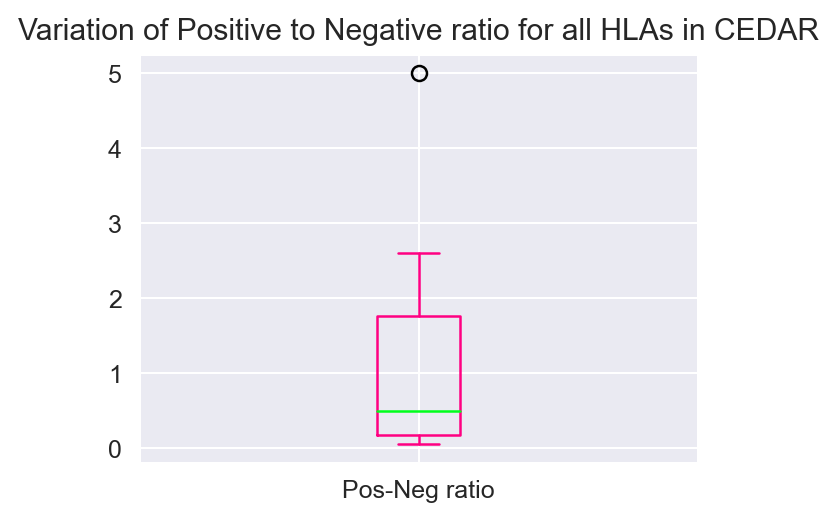

In [539]:
# POS-NEG ratio boxplot
pd.options.display.max_rows=999
gb_count = cedar.groupby(['HLA', 'agg_label'])[['Peptide']].count()
gb_total = cedar.groupby(['HLA'])[['Peptide']].count()
sorted_ratios = (ratios.query('agg_label==1') / ratios.query('agg_label==0'))[['Proportion']]\
    .rename(columns={'Proportion':'Pos-Neg ratio'})\
    .replace(np.nan, np.inf).sort_values('Pos-Neg ratio', ascending=False)
f,a = plt.subplots(1,1, figsize=(4,3))
sorted_ratios.plot(kind='box', title = 'Variation of Positive to Negative ratio for all HLAs in CEDAR', ax = a)
pd.options.display.max_rows=10

In [450]:
len(gb_count.query('agg_label==1')), len(gb_count.query('agg_label==0')), len(gb_count.reset_index(level=1).index.unique())

(63, 52, 63)

Text(0.5, 1.0, '% of Positive peptides vs number of positive peptides in dataset per HLA')

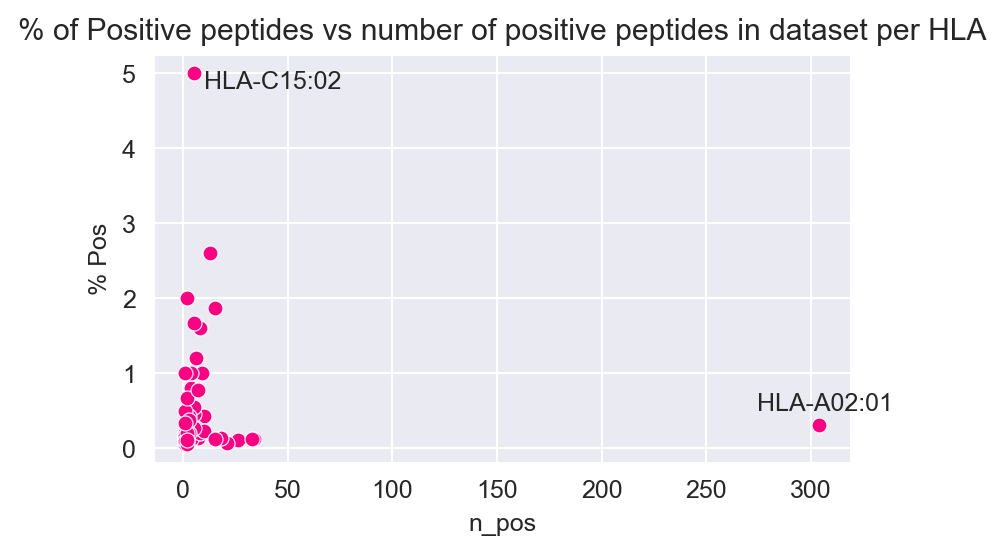

In [501]:
f,a = plt.subplots(1,1, figsize=(5,3))
npos_ratios = gb_count.query('agg_label==1').reset_index(level=1, drop=True).rename(columns={'Peptide':'n_pos'})\
                      .merge(sorted_ratios.rename(columns={'Pos-Neg ratio':'% Pos'}), left_index=True,right_index=True)
sns.scatterplot(data=npos_ratios, x = 'n_pos', y= '% Pos')

max_x = npos_ratios.iloc[npos_ratios['n_pos'].argmax()].name
max_y = npos_ratios.iloc[npos_ratios['% Pos'].replace(np.inf, 0).argmax()].name
# label outlier in x
a.text(npos_ratios.loc[max_x]['n_pos']-30, npos_ratios.loc[max_x]['% Pos']+0.2, max_x)
# label outlier in y
a.text(npos_ratios.loc[max_y]['n_pos']+5, npos_ratios.loc[max_y]['% Pos']-0.2, max_y)
a.set_title('% of Positive peptides vs number of positive peptides in dataset per HLA')

In [401]:
df.groupby(['add_rank']).agg({'score_concat_cedar_auc':'mean',
                              'score_concat_prime_auc':'mean'})

,score_concat_cedar_auc,score_concat_prime_auc
add_rank,,
False,0.554084,0.550799
True,0.576907,0.586149


## TOP params

### TOP method

In [516]:
def get_top_100(df, param_col, score_col, param_value=None):
    if param_value is None:
        values = df[param_col].unique()
        return {val:df.query(f'{param_col}==@val').sort_values(score_col, ascending=False).head(100) for val in values}
    else:
        return df.query(f'{param_col}==@param_value').sort_values(score_col, ascending=False).head(100)

In [518]:
top100_methods = get_top_100(df_simple, 'model', 'score_concat_cedar_auc')

In [ ]:
trainsetcedar_hp_rank_low_modelRF_weightKL_max_len12_encodingblosum_maskFalse_add_rankFalse_add_aapropFalse_
remove_pepFalse_standardizeFalse_blsmBL62FREQ

In [575]:
df_rf['outname'] = df_rf.apply(lambda x: ('_'.join([f'{col}{x[col]}' for col in [x for x in df_rf.columns if 'score' not in x and x!='outname']])).strip('_blsmnan'),
                              axis=1)

In [576]:
df_rf['outname'].values[0]

'trainsetcedar_modelRF_weightShannon_max_len12_encodingonehot_maskFalse_add_rankTrue_add_aapropTrue_remove_pepFalse_standardizeTrue'

In [540]:
df_rf.query('weight=="None"').sort_values('score_concat_cedar_auc',ascending=False).head(5)

,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm
20,cedar,RF,None,12,onehot,False,True,False,False,True,0.695253,0.554288,0.137652,0.695267,0.554232,0.137700,0.724143,0.579791,0.153394,0.722223,0.577292,0.152815,0.716188,0.576978,0.165937,NaN
21,cedar,RF,None,12,onehot,False,True,False,False,False,0.708789,0.560402,0.074018,0.708767,0.560380,0.074110,0.717687,0.576628,0.066879,0.715207,0.573959,0.066958,0.715281,0.574729,0.069688,NaN
17,cedar,RF,None,12,onehot,False,True,True,False,False,0.681939,0.544460,0.170802,0.681862,0.544386,0.170935,0.713113,0.570137,0.145949,0.711827,0.567490,0.147952,0.704778,0.570166,0.152934,NaN
320,cedar_virus,RF,None,12,onehot,False,True,False,False,True,0.704900,0.563836,0.266226,0.704856,0.563787,0.266305,0.711476,0.570187,0.197307,0.710422,0.569177,0.195062,0.712884,0.567965,0.230086,NaN
16,cedar,RF,None,12,onehot,False,True,True,False,True,0.693956,0.546173,0.119783,0.693866,0.546147,0.120052,0.709187,0.575892,0.078540,0.706681,0.570845,0.079096,0.703414,0.572788,0.089551,NaN


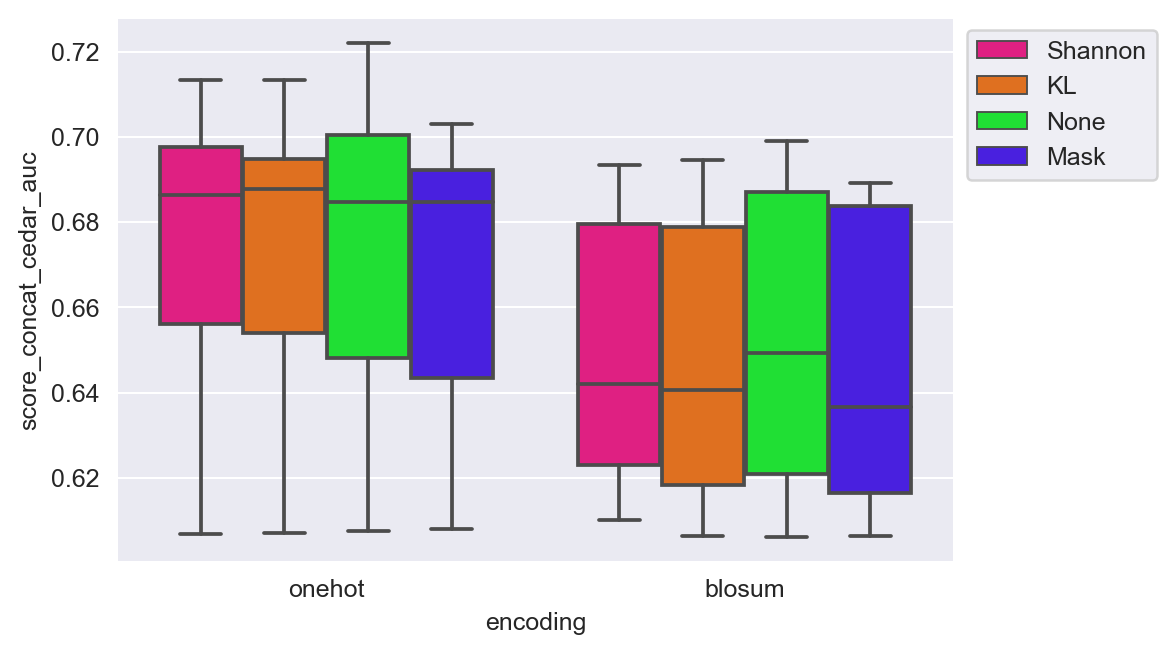

In [577]:
f,a = plt.subplots(1,1, figsize=(6,4))
sns.boxplot(data=pd.concat([x for _, x in top100_methods.items()]), x='encoding', hue='weight', y='score_concat_cedar_auc')
a.legend(bbox_to_anchor=(1,1))

In [425]:
top_prime = df_simple.sort_values('score_concat_prime_auc', ascending=False).head(100)
top_cedar = df_simple.sort_values('score_concat_cedar_auc', ascending=False).head(100)
top_valid = df_simple.sort_values('score_avg_valid_auc', ascending=False).head(100)

In [426]:
display(top_prime.head(5)[hyperparams_col.to_list()+['score_concat_prime_auc']])
display(top_cedar.head(5)[hyperparams_col.to_list()+['score_concat_cedar_auc']])
display(top_valid.head(5)[hyperparams_col.to_list()+['score_avg_valid_auc']])

,add_aaprop,add_rank,blsm,encoding,model,remove_pep,standardize,trainset,weight,score_concat_prime_auc
660,True,True,BL62FREQ,blosum,RF,False,True,cedar_hp_rank_uni,Mask,0.712916
628,True,True,NaN,onehot,RF,False,True,cedar_hp_rank_uni,Mask,0.712710
636,True,True,BL62FREQ,blosum,RF,False,True,cedar_hp_rank_uni,Shannon,0.712673
629,True,True,NaN,onehot,RF,False,False,cedar_hp_rank_uni,Mask,0.712622
661,True,True,BL62FREQ,blosum,RF,False,False,cedar_hp_rank_uni,Mask,0.712609


,add_aaprop,add_rank,blsm,encoding,model,remove_pep,standardize,trainset,weight,score_concat_cedar_auc
420,False,True,NaN,onehot,RF,False,True,cedar,None,0.722223
421,False,True,NaN,onehot,RF,False,False,cedar,None,0.715207
401,True,True,NaN,onehot,RF,False,False,cedar,Shannon,0.713380
409,True,True,NaN,onehot,RF,False,False,cedar,KL,0.713340
400,True,True,NaN,onehot,RF,False,True,cedar,Shannon,0.712947


,add_aaprop,add_rank,blsm,encoding,model,remove_pep,standardize,trainset,weight,score_avg_valid_auc
620,False,True,NaN,onehot,RF,False,True,cedar_hp_rank_uni,None,0.831797
621,False,True,NaN,onehot,RF,False,False,cedar_hp_rank_uni,None,0.831713
909,True,True,NaN,onehot,XGB,False,False,cedar_hp_rank_uni,KL,0.830574
910,False,True,NaN,onehot,XGB,False,True,cedar_hp_rank_uni,KL,0.830459
908,True,True,NaN,onehot,XGB,False,True,cedar_hp_rank_uni,KL,0.830174


In [431]:
(top_valid.groupby('model')[['blsm']].count()+top_cedar.groupby('model')[['blsm']].count()+top_prime.groupby('model')[['blsm']].count()).replace(np.nan,8)

,blsm
model,
FFN,8.0
RF,87.0
XGB,61.0


In [432]:
df_simple.loc[cedar_auc['best_idx']].groupby(['add_rank','add_aaprop','weight','encoding']).count()[['model']].sort_values('model', ascending=False).head(10)

model
add_rank add_aaprop weight  encoding       
True     False      None    onehot       11
         True       Shannon onehot        9
                            blosum        9
                    None    onehot        7
                    KL      blosum        7
         False      None    blosum        7
False    True       Shannon blosum        6
True     False      KL      onehot        6
                    Shannon onehot        6
         True       KL      onehot        6

In [278]:
print('\ncedar_auc')
display(df_simple.loc[cedar_auc['best_idx']].drop(columns=['lr','wd']).groupby(['add_rank','add_aaprop','weight','encoding']).count()[['model']].sort_values('model', ascending=False).head(10))
print('\nprime_auc')
display(df_simple.loc[prime_auc['best_idx']].drop(columns=['lr','wd']).groupby(['add_rank','add_aaprop','weight','encoding']).count()[['model']].sort_values('model', ascending=False).head(10))
print('\nvalid_auc')
display(df_simple.loc[valid_auc['best_idx']].drop(columns=['lr','wd']).groupby(['add_rank','add_aaprop','weight','encoding']).count()[['model']].sort_values('model', ascending=False).head(10))



cedar_auc


model
add_rank add_aaprop weight  encoding       
True     False      None    onehot       11
                            blosum        9
         True       Shannon onehot        9
False    True       Shannon blosum        8
True     True       KL      blosum        7
                    None    blosum        7
                            onehot        7
         False      KL      onehot        6
False    True       KL      blosum        6
True     False      Shannon onehot        6


prime_auc


model
add_rank add_aaprop weight  encoding       
True     False      KL      onehot       15
                    None    blosum       14
                    Shannon onehot       12
                            blosum        7
         True       None    blosum        7
                    KL      blosum        6
                            onehot        6
                    Mask    blosum        6
         False      KL      blosum        5
         True       Shannon blosum        5


valid_auc


model
add_rank add_aaprop weight  encoding       
True     False      None    blosum       15
                            onehot       10
         True       None    blosum        9
         False      KL      onehot        7
         True       None    onehot        7
         False      KL      blosum        6
                    Mask    onehot        6
                    Shannon blosum        6
                            onehot        6
                    Mask    blosum        5

In [ ]:
# Models : RF, LogReg, XGB, FFN
# Trainsets : cedar, cedar_hp_rank_low, cedar_hp_rank_uni, cedar_virus

In [375]:
df_simple.columns

Index(['add_aaprop', 'add_rank', 'blsm', 'encoding', 'lr', 'mask', 'model',
       'remove_pep', 'score_avg_cedar_auc', 'score_avg_prime_auc',
       'score_avg_valid_auc', 'standardize', 'trainset', 'wd', 'weight'],
      dtype='object')

## AUC boxplots

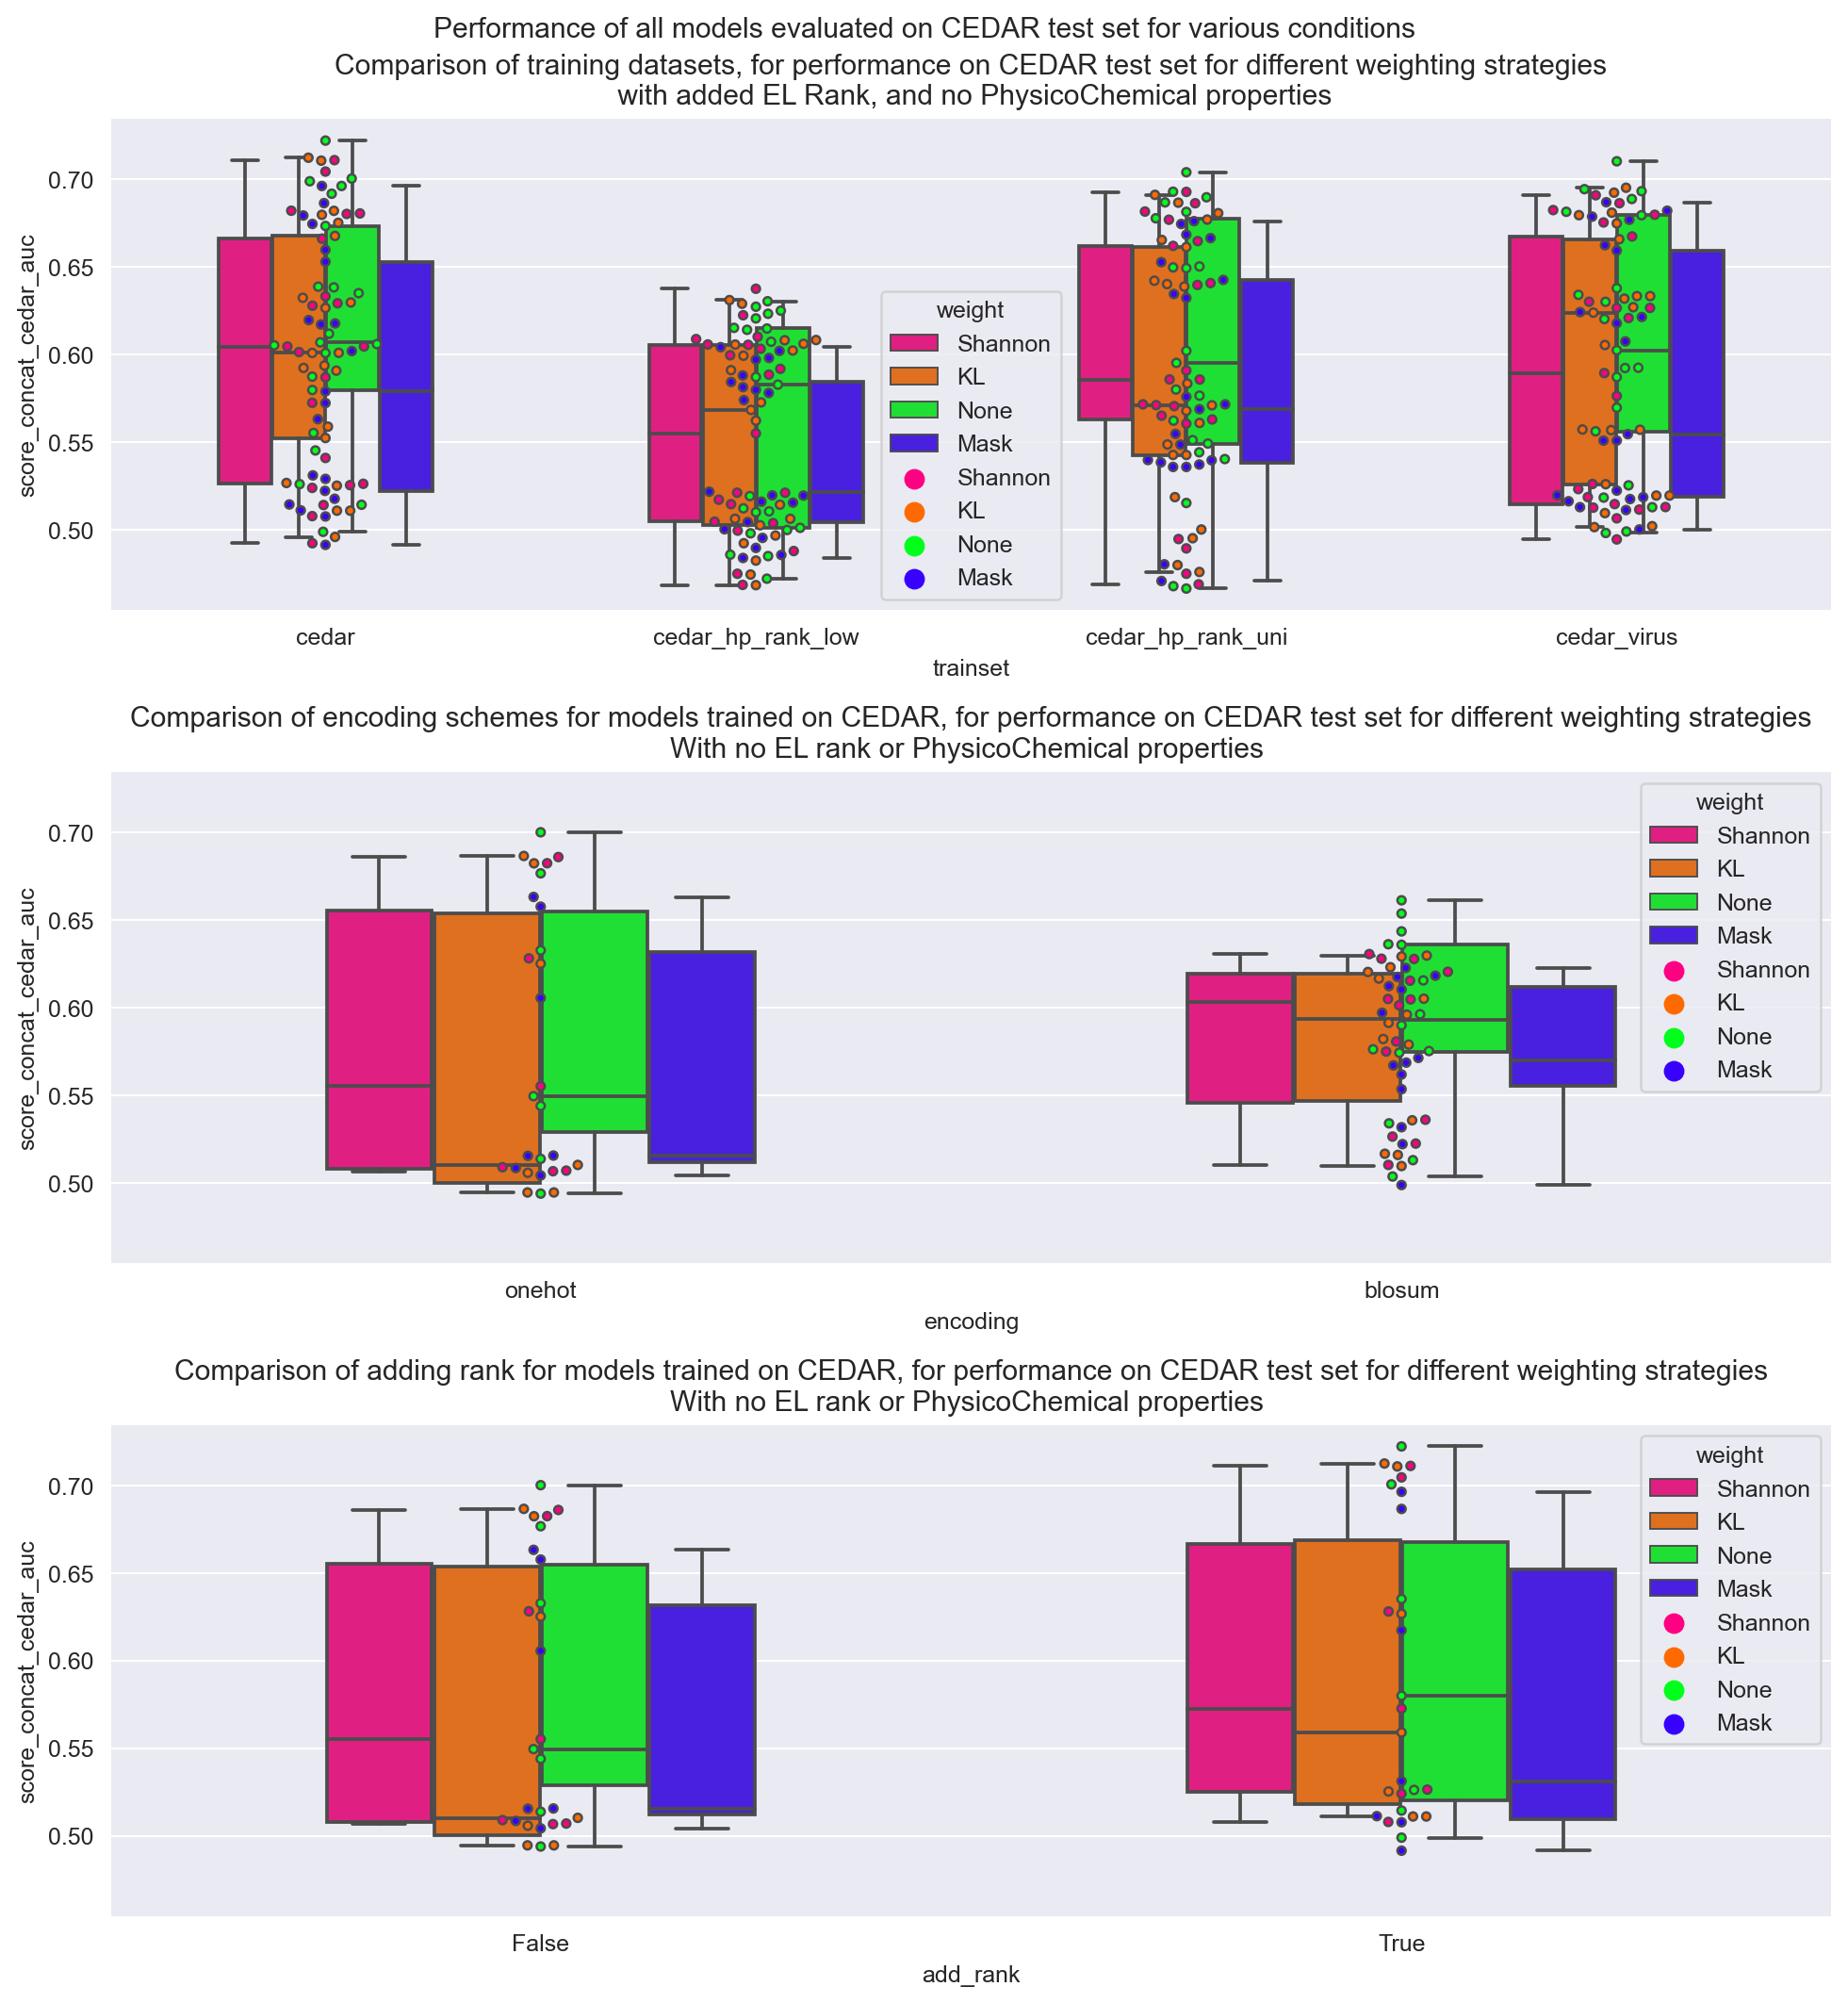

In [396]:
f,a = plt.subplots(3,1, figsize=(11,12), sharey=True)
PAL = sns.color_palette('hsv', n_colors=13)
palette = [PAL[-1], PAL[0], PAL[4], PAL [-4]]
f.suptitle('Performance of all models evaluated on CEDAR test set for various conditions')
sns.set_palette(palette)
# 1

sns.boxplot(data=df_simple.query('add_rank==True and remove_pep==False and add_aaprop == False and standardize==True')
                ,x= 'trainset' , hue= 'weight', y = 'score_concat_cedar_auc', hue_order = ['Shannon', 'KL', 'None', 'Mask'], ax = a[0], width=0.5)
sns.swarmplot(data=df_simple.query('add_rank==True and remove_pep==False and add_aaprop == False and standardize==True')
                ,x= 'trainset' , hue= 'weight', y = 'score_concat_cedar_auc', hue_order = ['Shannon', 'KL', 'None', 'Mask'], ax = a[0], linewidth=1, size = 3.5)
a[0].set_title('Comparison of training datasets, for performance on CEDAR test set for different weighting strategies\n with added EL Rank, and no PhysicoChemical properties')
# 2


sns.boxplot(data=df_simple.query('trainset=="cedar" and add_rank==False and add_aaprop==False and remove_pep==False and standardize==True')
                ,x='encoding', y = 'score_concat_cedar_auc', hue = 'weight', hue_order = ['Shannon', 'KL', 'None', 'Mask'], ax = a[1], width=0.5)
sns.swarmplot(data=df_simple.query('trainset=="cedar" and add_rank==False and add_aaprop==False and remove_pep==False and standardize==True')
                ,x='encoding', y = 'score_concat_cedar_auc', hue = 'weight', hue_order = ['Shannon', 'KL', 'None', 'Mask'], ax = a[1], linewidth=1, size = 3.5)
a[1].set_title('Comparison of encoding schemes for models trained on CEDAR, for performance on CEDAR test set for different weighting strategies\nWith no EL rank or PhysicoChemical properties ')
# 

sns.boxplot(data=df_simple.query('trainset=="cedar" and encoding=="onehot" and add_aaprop ==False and remove_pep==False and standardize==True')
                ,x='add_rank', hue = 'weight', y='score_concat_cedar_auc', hue_order = ['Shannon', 'KL', 'None', 'Mask'], ax = a[2], width=0.5)
sns.swarmplot(data=df_simple.query('trainset=="cedar" and encoding=="onehot" and add_aaprop ==False and remove_pep==False and standardize==True')
                ,x='add_rank', hue = 'weight', y='score_concat_cedar_auc', hue_order = ['Shannon', 'KL', 'None', 'Mask'], ax = a[2], linewidth=1, size = 3.5)
a[2].set_title('Comparison of adding rank for models trained on CEDAR, for performance on CEDAR test set for different weighting strategies\nWith no EL rank or PhysicoChemical properties ')
f.tight_layout()

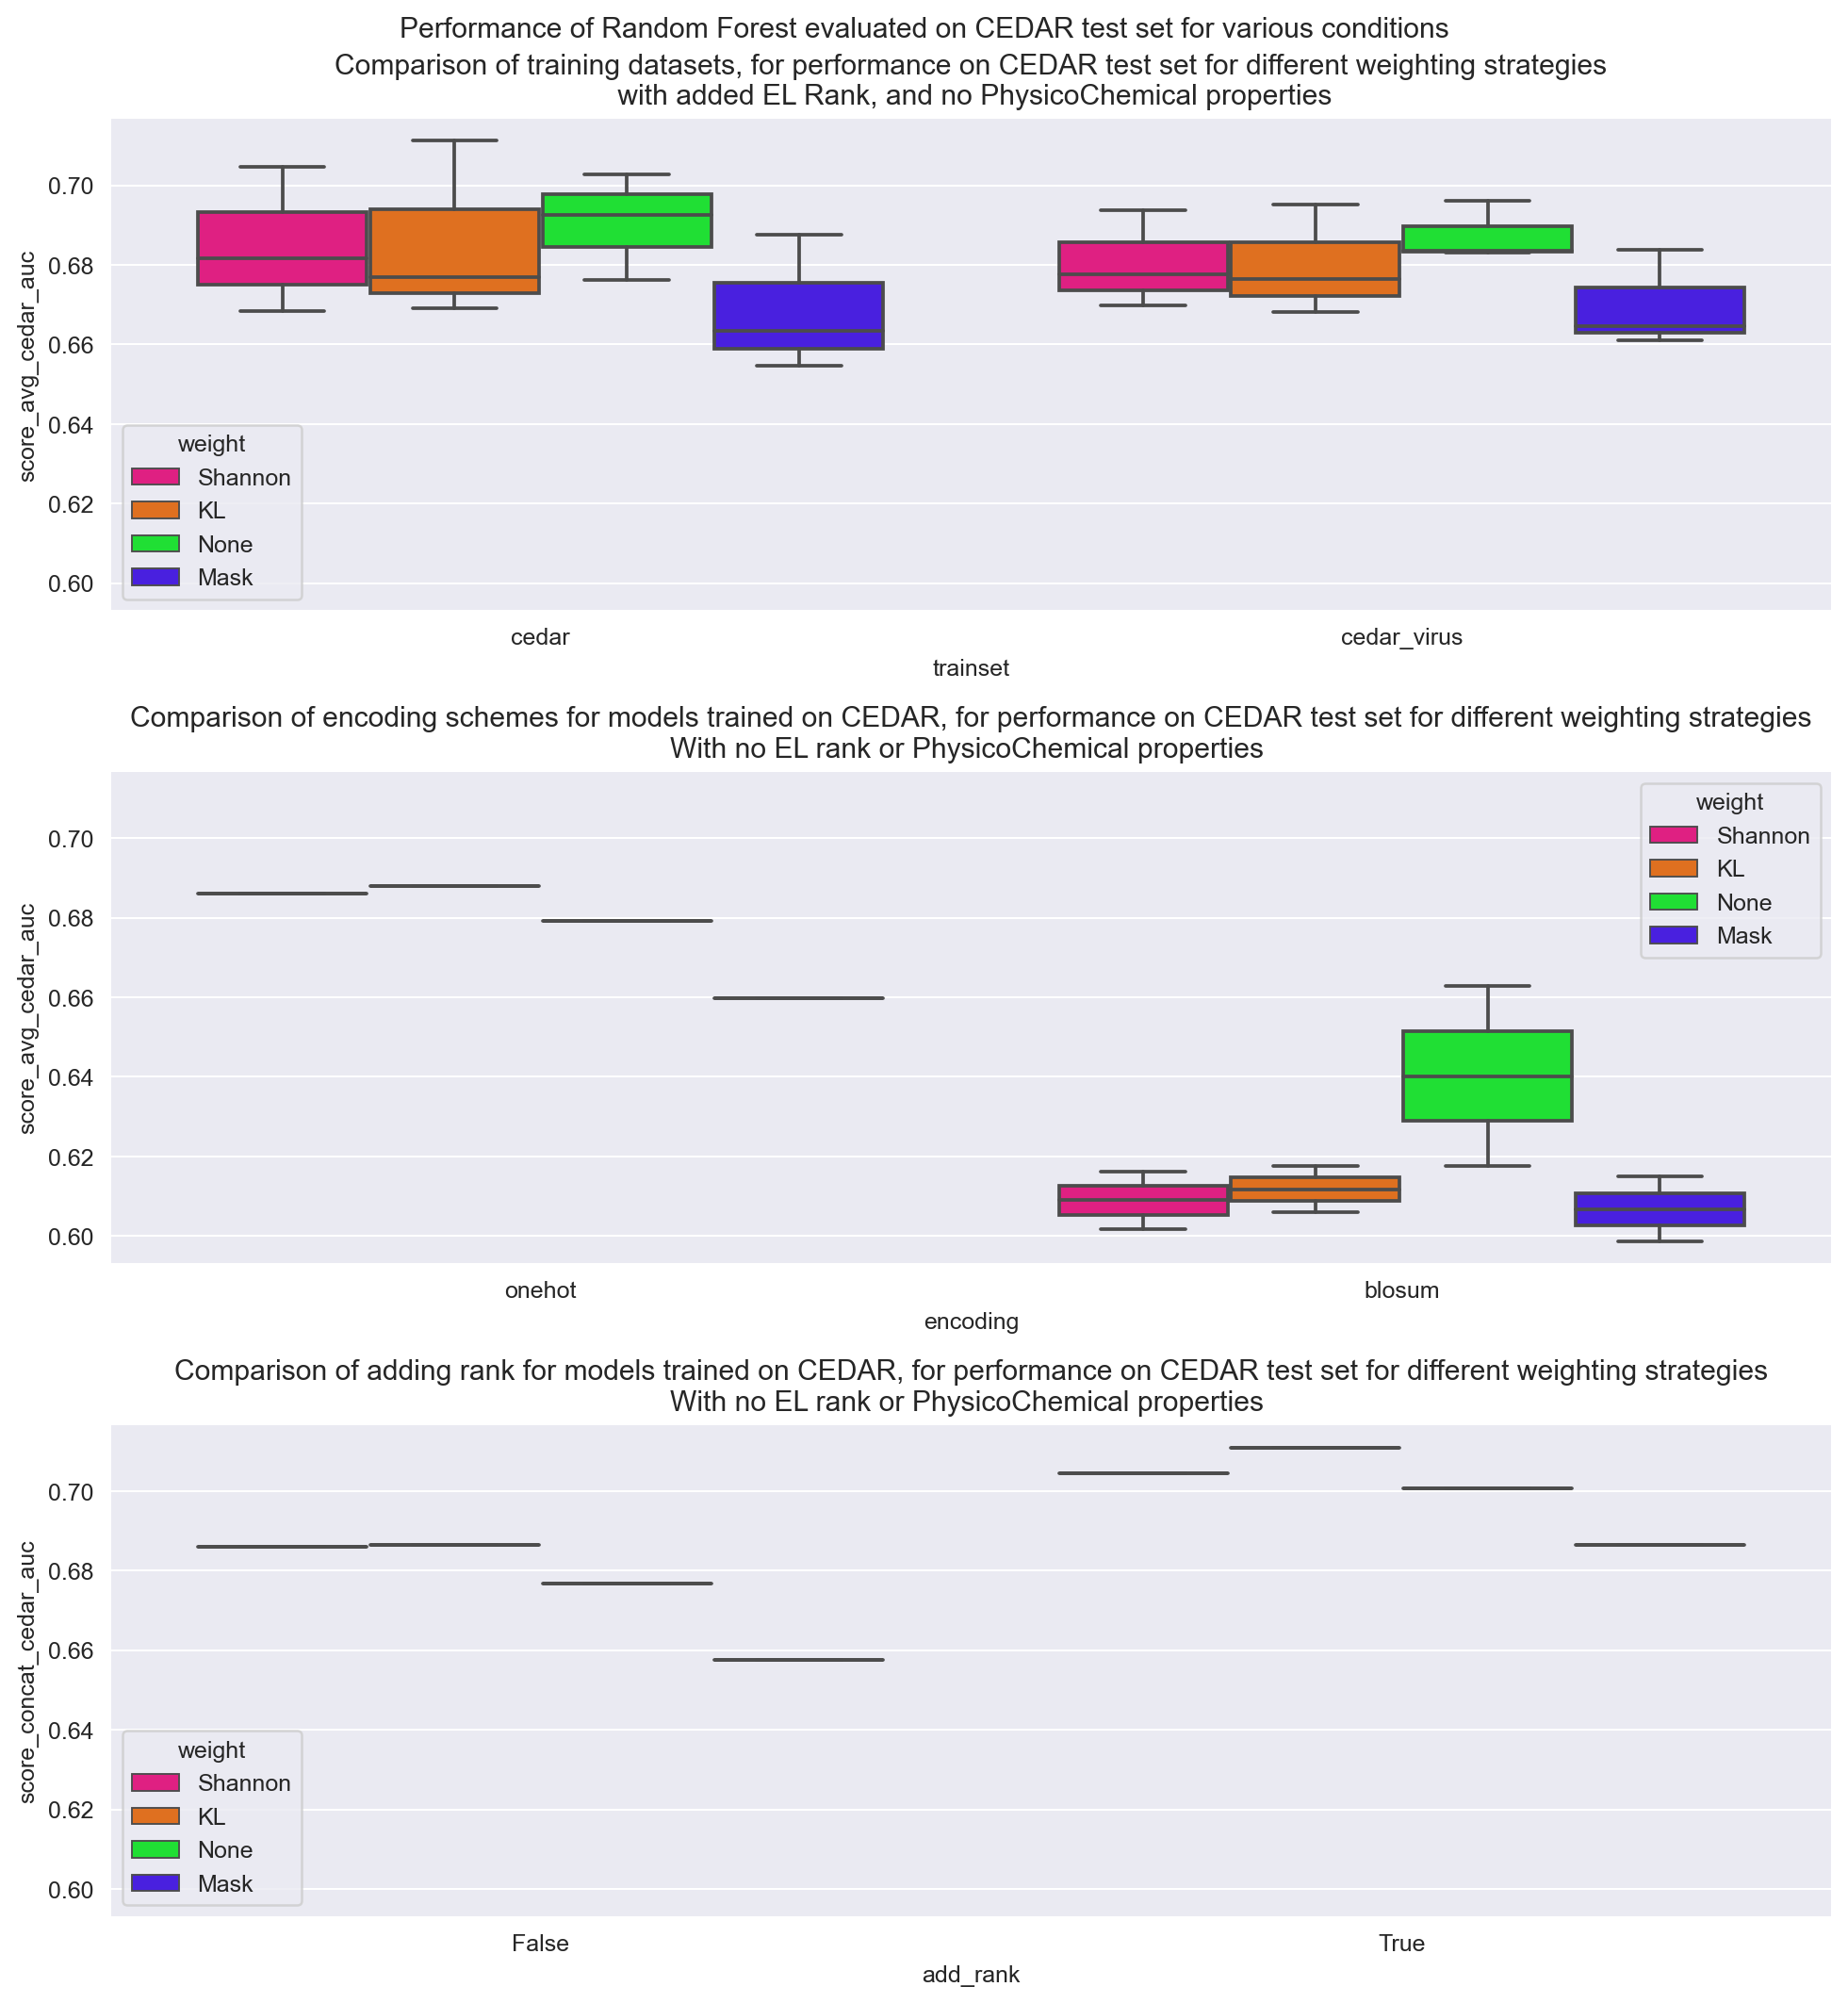

In [328]:
f,a = plt.subplots(3,1, figsize=(11,12), sharey=True)
PAL = sns.color_palette('hsv', n_colors=13)
palette = [PAL[-1], PAL[0], PAL[4], PAL [-4]]
f.suptitle('Performance of Random Forest evaluated on CEDAR test set for various conditions')
sns.set_palette(palette)
rf_subset=df_rf
# 1
sns.boxplot(data=df_xgb_normal.query('add_rank==True and remove_pep==False and add_aaprop == False and standardize==True'),
            orient='v',x= 'trainset' , hue= 'weight', y = 'score_avg_cedar_auc', hue_order = ['Shannon', 'KL', 'None', 'Mask'], ax = a[0])
a[0].set_title('Comparison of training datasets, for performance on CEDAR test set for different weighting strategies\n with added EL Rank, and no PhysicoChemical properties')
# 2

sns.boxplot(data=df_xgb_normal.query('trainset=="cedar" and add_rank==False and add_aaprop==False and remove_pep==False and standardize==True'),
            orient='v', x='encoding', y = 'score_avg_cedar_auc', hue = 'weight', hue_order = ['Shannon', 'KL', 'None', 'Mask'], ax = a[1])
a[1].set_title('Comparison of encoding schemes for models trained on CEDAR, for performance on CEDAR test set for different weighting strategies\nWith no EL rank or PhysicoChemical properties ')
# 
sns.boxplot(data=df_xgb_normal.query('trainset=="cedar" and encoding=="onehot" and add_aaprop ==False and remove_pep==False and standardize==True'),
            orient='v',
            x='add_rank', hue = 'weight', y='score_concat_cedar_auc', hue_order = ['Shannon', 'KL', 'None', 'Mask'], ax = a[2])
a[2].set_title('Comparison of adding rank for models trained on CEDAR, for performance on CEDAR test set for different weighting strategies\nWith no EL rank or PhysicoChemical properties ')
f.tight_layout()

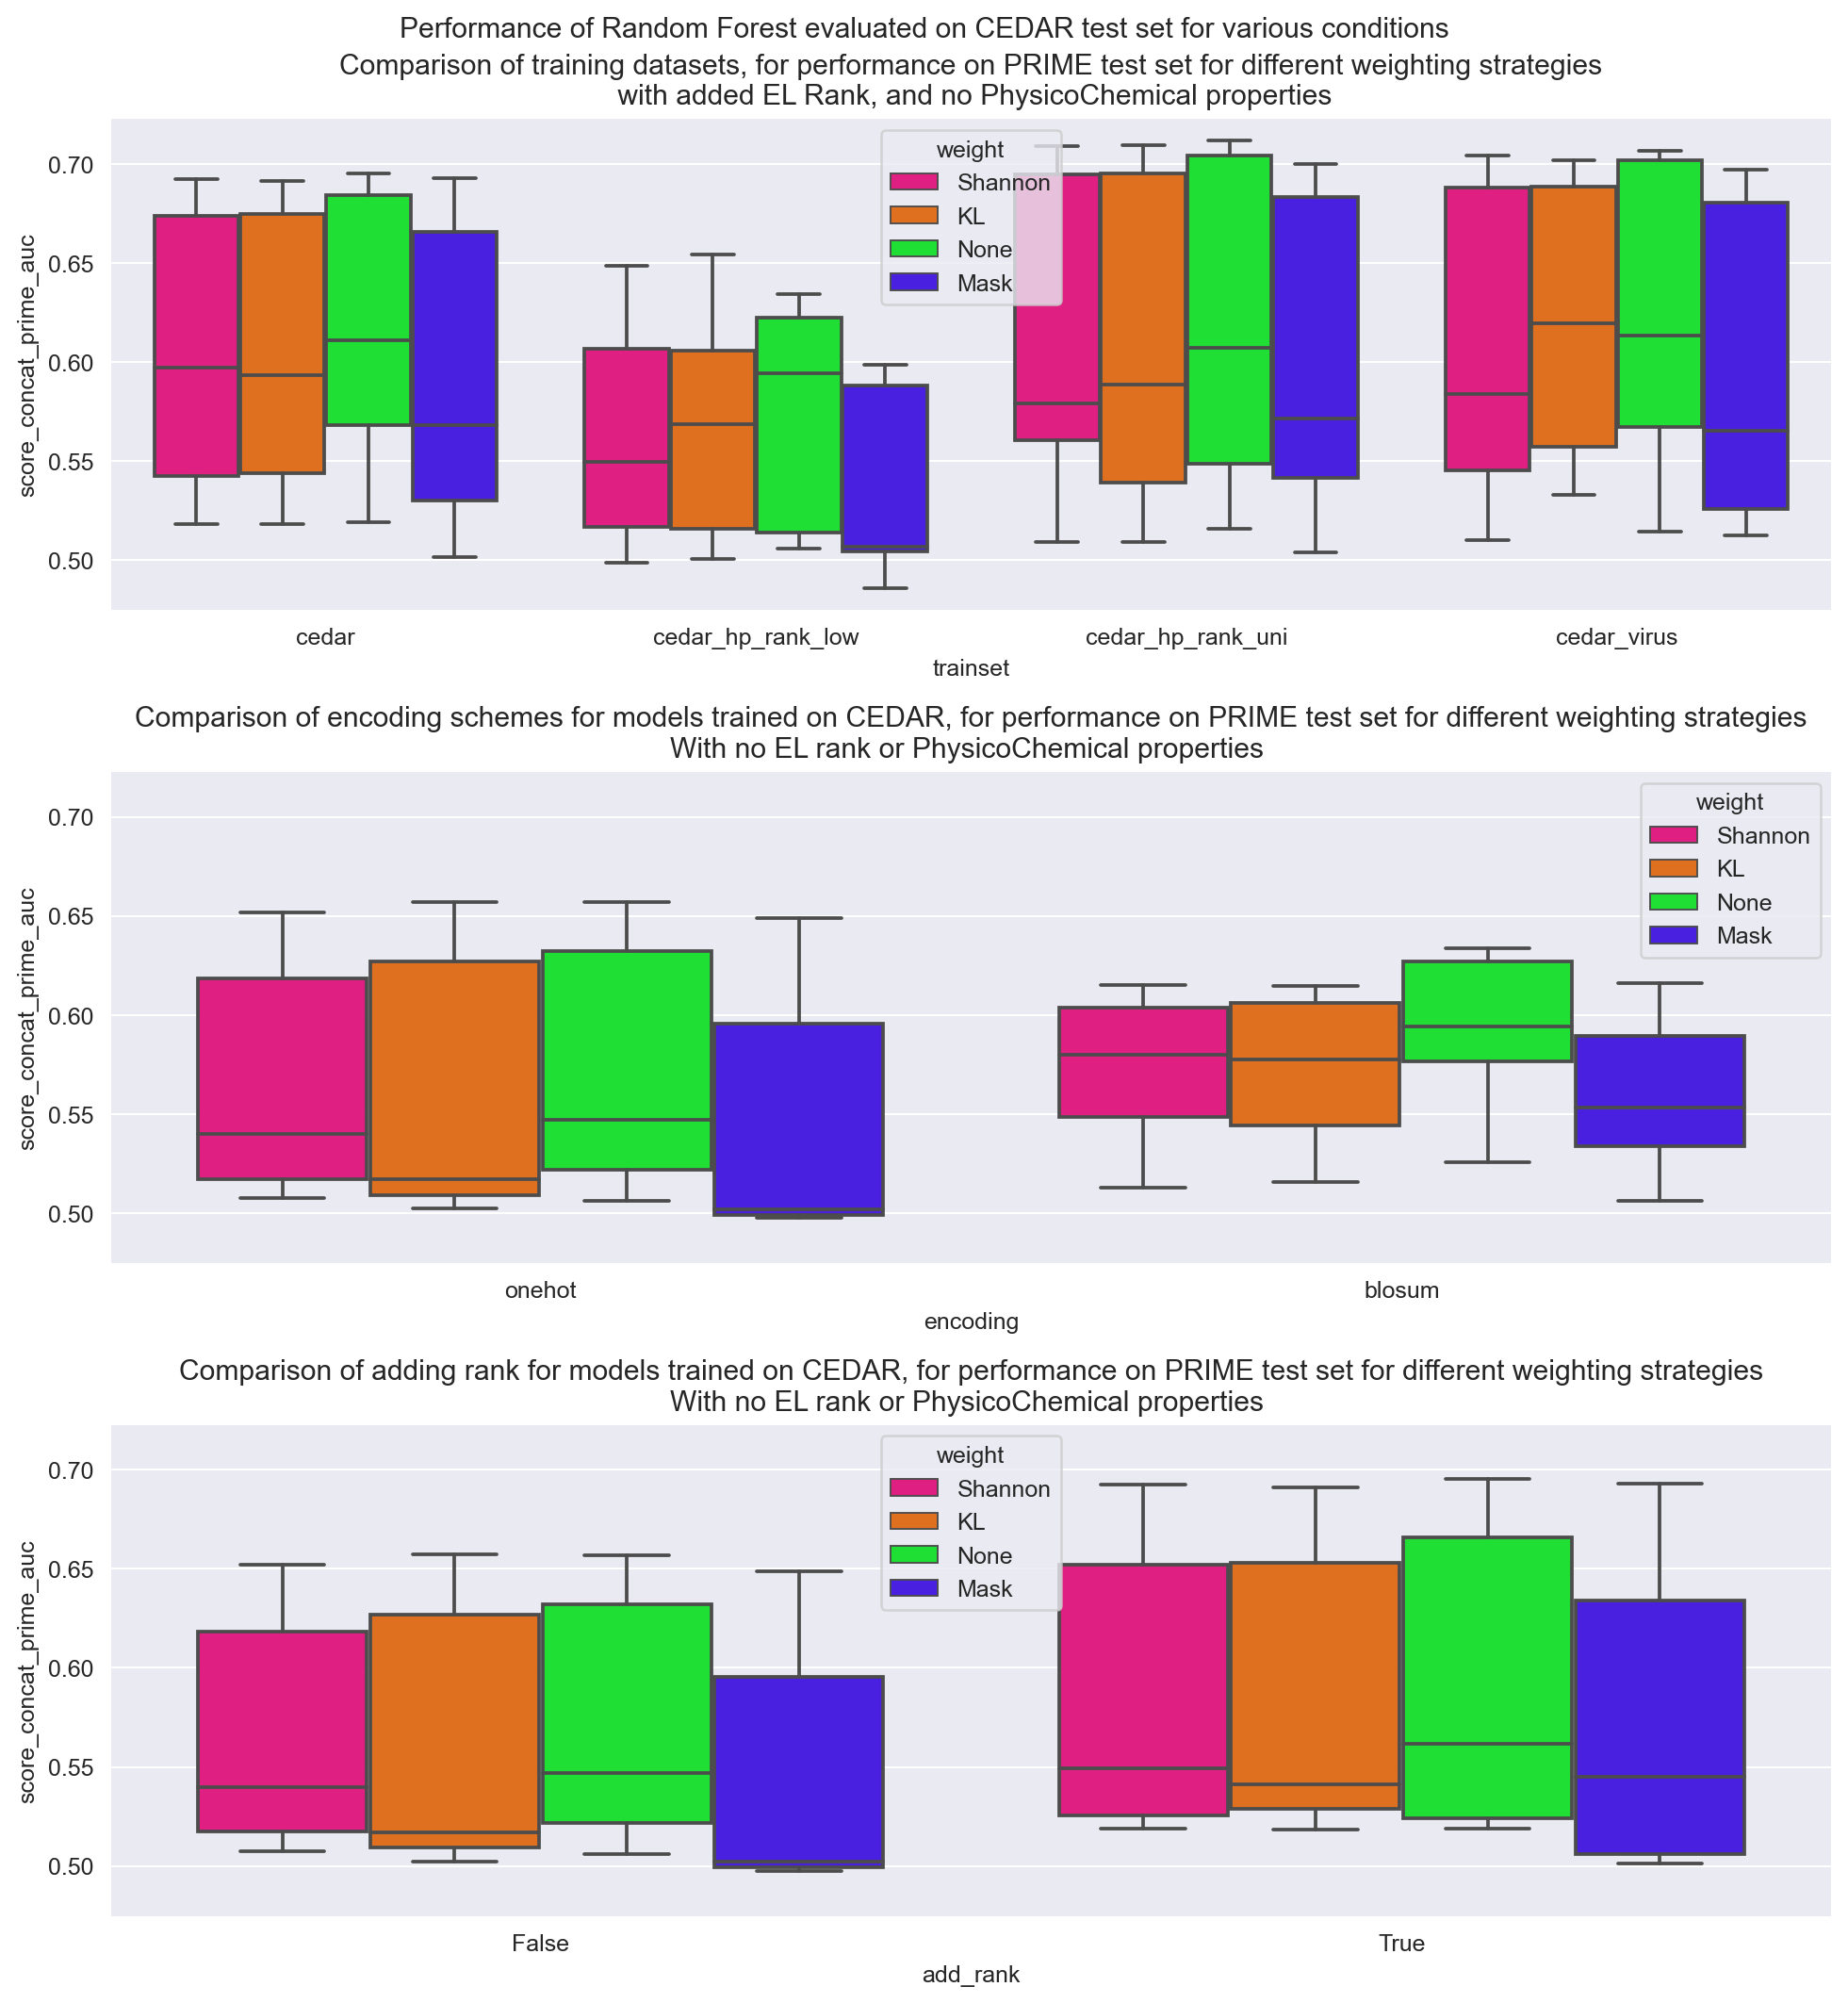

In [382]:
f,a = plt.subplots(3,1, figsize=(11,12), sharey=True)
PAL = sns.color_palette('hsv', n_colors=13)
palette = [PAL[-1], PAL[0], PAL[4], PAL [-4]]

f.suptitle('Performance of Random Forest evaluated on CEDAR test set for various conditions')
sns.set_palette(palette)
# 1
sns.boxplot(data=df_simple.query('add_rank==True and remove_pep==False and add_aaprop == False and standardize==True'),
            orient='v',x= 'trainset' , hue= 'weight', y = 'score_concat_prime_auc', hue_order = ['Shannon', 'KL', 'None', 'Mask'], ax = a[0])
a[0].set_title('Comparison of training datasets, for performance on PRIME test set for different weighting strategies\n with added EL Rank, and no PhysicoChemical properties')
# 2

sns.boxplot(data=df_simple.query('trainset=="cedar" and add_rank==False and add_aaprop==False and remove_pep==False and standardize==True'),
            orient='v', x='encoding', y = 'score_concat_prime_auc', hue = 'weight', hue_order = ['Shannon', 'KL', 'None', 'Mask'], ax = a[1])
a[1].set_title('Comparison of encoding schemes for models trained on CEDAR, for performance on PRIME test set for different weighting strategies\nWith no EL rank or PhysicoChemical properties ')
# 
sns.boxplot(data=df_simple.query('trainset=="cedar" and encoding=="onehot" and add_aaprop ==False and remove_pep==False and standardize==True'),
            orient='v',
            x='add_rank', hue = 'weight', y='score_concat_prime_auc', hue_order = ['Shannon', 'KL', 'None', 'Mask'], ax = a[2])
a[2].set_title('Comparison of adding rank for models trained on CEDAR, for performance on PRIME test set for different weighting strategies\nWith no EL rank or PhysicoChemical properties ')
f.tight_layout()